In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, GroupKFold
from sklearn.model_selection import StratifiedGroupKFold

sns.set_style("whitegrid")

df = pd.read_csv("/home/maxc/workspace/kaggle-hms/hms-harmful-brain-activity-classification/train.csv")
TARGETS = df.columns[-6:]
str(list(TARGETS))

"['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']"

In [2]:
# group by eeg_id to generate folds
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()


In [3]:
print(train.shape)
train.head()

(17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [4]:
from sklearn.model_selection import KFold, GroupKFold
gkf = GroupKFold(n_splits=5)

non_overlap_train = train.copy()
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):  

    # append i to the dataframe
    non_overlap_train.loc[valid_index, 'fold'] = int(i)
non_overlap_train['fold'] = non_overlap_train['fold'].astype(int)


In [5]:
fold_df = non_overlap_train[['eeg_id','fold']].copy()

train_df_fold = pd.merge(df, fold_df, on='eeg_id', how='left')
print(train_df_fold.shape)
# normalize targets by the sum

central_idx = train_df_fold['eeg_label_offset_seconds'].apply(lambda x: int(x)//20)
train_df_fold['central_id'] = train_df_fold['eeg_id'].astype(str) + '_' + central_idx.astype(str)

non_overlap_eeg_id = train_df_fold['eeg_label_offset_seconds'].apply(lambda x: int(x)//50)
train_df_fold['nonoverlap_eeg_id'] = train_df_fold['eeg_id'].astype(str) + '_' + non_overlap_eeg_id.astype(str)


unique_label_columns = ['eeg_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
train_df_fold['unique_label'] = train_df_fold[unique_label_columns].apply(lambda x: '_'.join(x.astype(str)), axis=1)
train_df_fold.head()


train_df_fold["unique_id"] = train_df_fold["eeg_id"].astype(str) + "_" + train_df_fold["eeg_sub_id"].astype(str)

train_df_fold["total_votes"] = train_df_fold[["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]].sum(axis=1)


(106800, 16)


In [6]:
import torch

y_data = train_df_fold[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)

target_tensor = torch.tensor(y_data, dtype=torch.float32)
mean_tensor = 1/6 * torch.ones_like(target_tensor)
kl_div = torch.nn.functional.kl_div(mean_tensor.log(),target_tensor, reduction='none')
kl_div = kl_div.sum(dim=1)
kl_div = kl_div.numpy()

train_df_fold['kl_div'] = kl_div
train_df_fold.head()


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,...,lrda_vote,grda_vote,other_vote,fold,central_id,nonoverlap_eeg_id,unique_label,unique_id,total_votes,kl_div
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,...,0,0,0,1,1628180742_0,1628180742_0,1628180742_3_0_0_0_0_0,1628180742_0,3,1.791759
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,...,0,0,0,1,1628180742_0,1628180742_0,1628180742_3_0_0_0_0_0,1628180742_1,3,1.791759
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,...,0,0,0,1,1628180742_0,1628180742_0,1628180742_3_0_0_0_0_0,1628180742_2,3,1.791759
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,...,0,0,0,1,1628180742_0,1628180742_0,1628180742_3_0_0_0_0_0,1628180742_3,3,1.791759
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,...,0,0,0,1,1628180742_1,1628180742_0,1628180742_3_0_0_0_0_0,1628180742_4,3,1.791759


(array([   82.,   667.,  2606.,  5278.,  8945.,  4998., 23037.,  6088.,
         4062., 51037.]),
 array([0.03765416, 0.2130647 , 0.38847524, 0.56388575, 0.73929632,
        0.91470683, 1.09011734, 1.26552784, 1.44093847, 1.61634898,
        1.79175949]),
 <BarContainer object of 10 artists>)

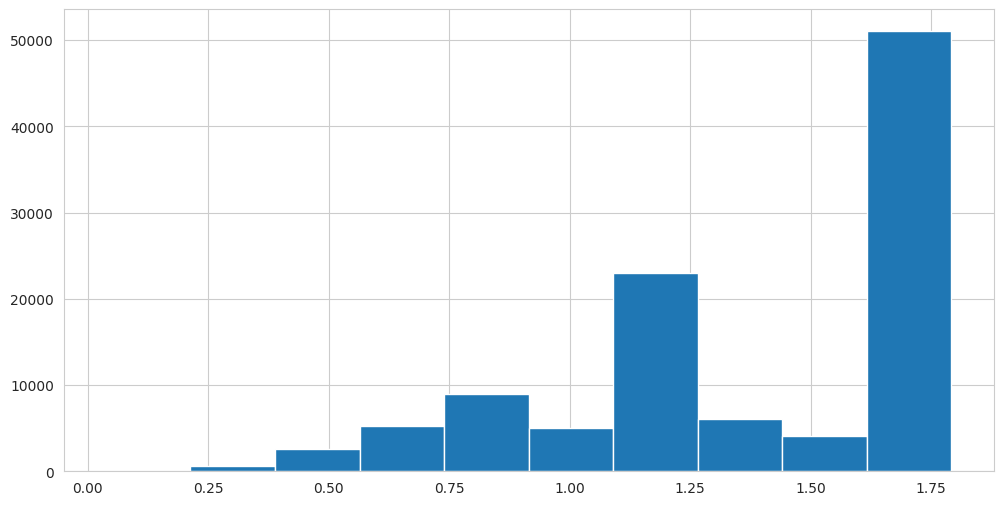

In [7]:
# plot the distribution of kl_div
import seaborn as sns
plt.figure(figsize=(12,6))
plt.hist(kl_div, bins=10)

In [8]:
print(train_df_fold['central_id'].nunique())
print(train_df_fold['nonoverlap_eeg_id'].nunique())
print(train_df_fold['unique_label'].nunique())
print(train_df_fold['eeg_id'].nunique())

36722
23432
20183
17089


In [9]:
target_df = train_df_fold.copy()
y_data = target_df[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
target_df[TARGETS] = y_data

target_df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,...,lrda_vote,grda_vote,other_vote,fold,central_id,nonoverlap_eeg_id,unique_label,unique_id,total_votes,kl_div
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,...,0.0,0.0,0.0,1,1628180742_0,1628180742_0,1628180742_3_0_0_0_0_0,1628180742_0,3,1.791759
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,1.0,...,0.0,0.0,0.0,1,1628180742_0,1628180742_0,1628180742_3_0_0_0_0_0,1628180742_1,3,1.791759
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,1.0,...,0.0,0.0,0.0,1,1628180742_0,1628180742_0,1628180742_3_0_0_0_0_0,1628180742_2,3,1.791759
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,1.0,...,0.0,0.0,0.0,1,1628180742_0,1628180742_0,1628180742_3_0_0_0_0_0,1628180742_3,3,1.791759
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,1.0,...,0.0,0.0,0.0,1,1628180742_1,1628180742_0,1628180742_3_0_0_0_0_0,1628180742_4,3,1.791759


In [11]:
folds_dir = "/home/maxc/workspace/kaggle-hms/folds"


train_df_fold.to_csv(f"{folds_dir}/all_folds.csv", index=False)
target_df.to_csv(f"{folds_dir}/all_targets.csv", index=False)

for fold_idx in range(5):
    val_df = train_df_fold[train_df_fold['fold'] == fold_idx]
    train_df = train_df_fold[train_df_fold['fold'] != fold_idx]

    train_df.to_csv(f"{folds_dir}/train_fold_{fold_idx}.csv", index=False)
    val_df.to_csv(f"{folds_dir}/val_fold_{fold_idx}.csv", index=False)

(22104, 22)


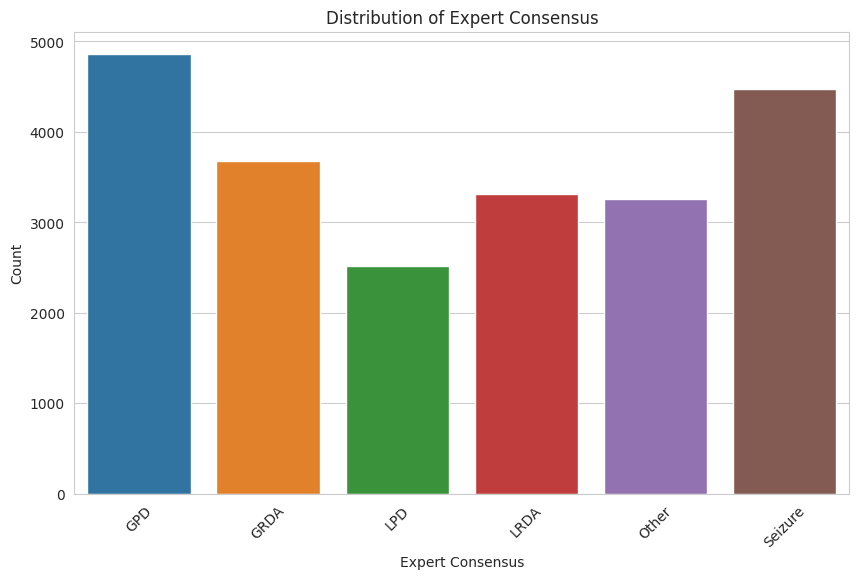

(20426, 22)


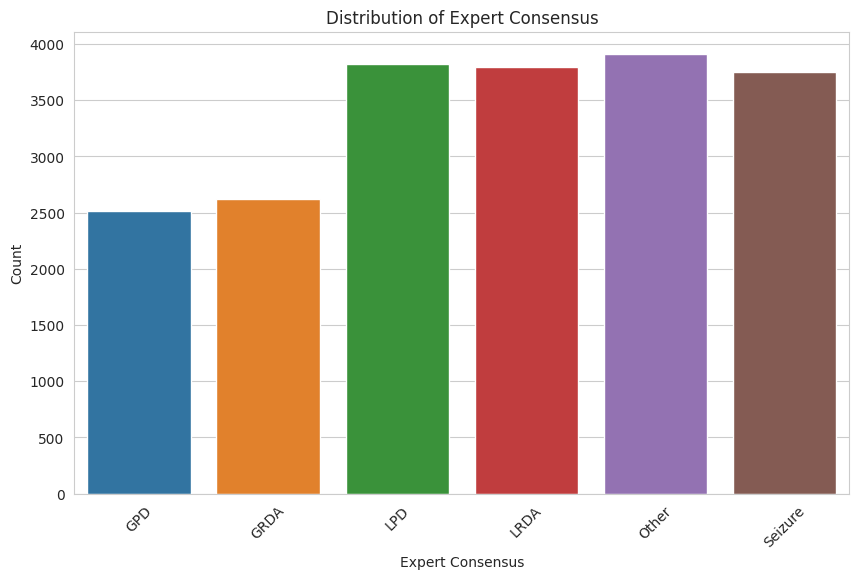

(21039, 22)


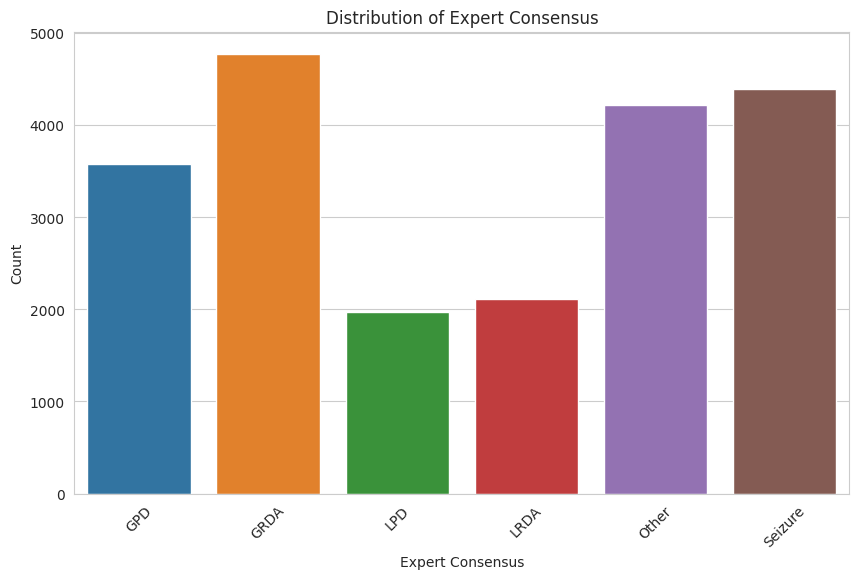

(22305, 22)


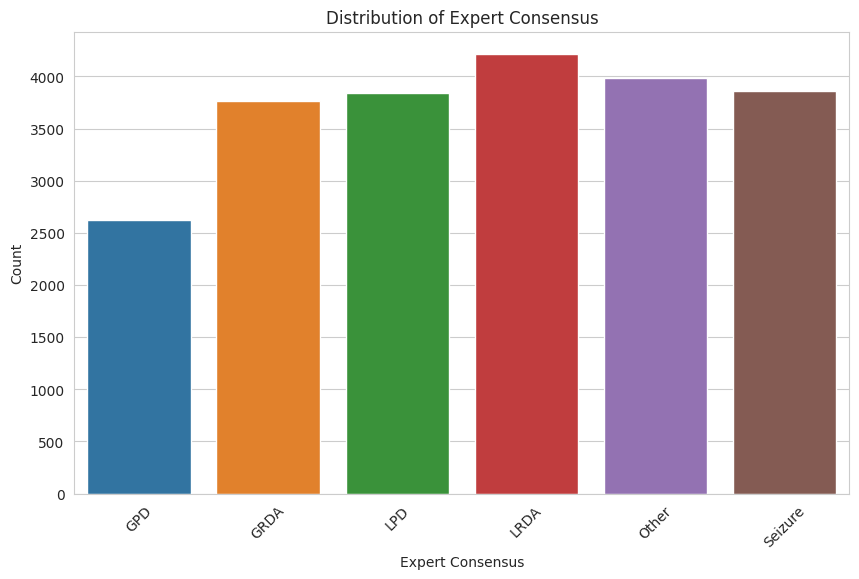

(20926, 22)


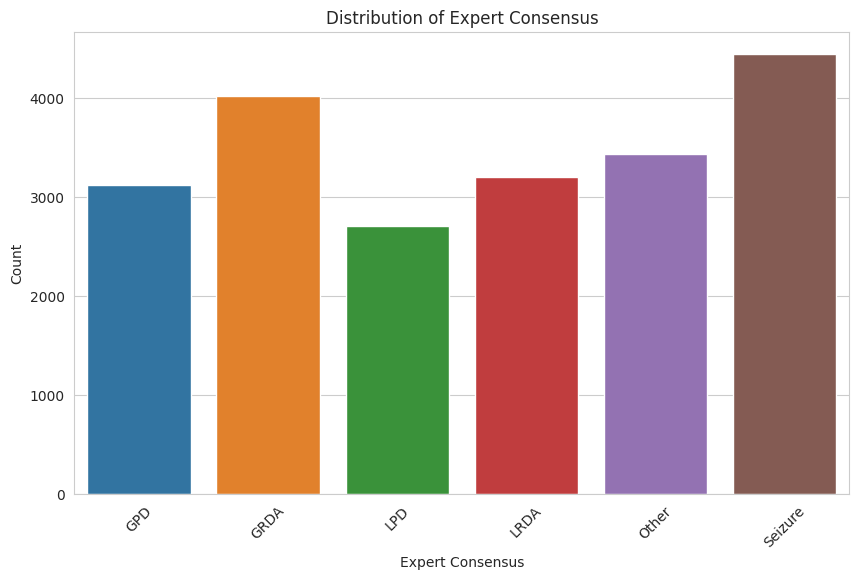

In [12]:
import seaborn as sns

# grouped_df = df.groupby('eeg_id').agg('first')
# print(grouped_df.shape)
# df = grouped_df.copy()
for fold_idx in range(5):
    fold_df = train_df_fold[train_df_fold['fold'] == fold_idx]
    target_order = fold_df['expert_consensus'].value_counts().sort_index().index

    print(fold_df.shape)
    plt.figure(figsize=(10, 6))
    sns.countplot(data=fold_df, x='expert_consensus', order=target_order)
    plt.title('Distribution of Expert Consensus')
    plt.xlabel('Expert Consensus')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [13]:
# sort by eeg_id
df = df.sort_values('eeg_id')
df.head()


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
40927,568657,0,0.0,789577333,0,0.0,1825637311,20654,Other,0,0,3,0,2,7
40928,568657,1,6.0,789577333,1,6.0,3640441665,20654,Other,0,0,3,0,2,7
40929,568657,2,12.0,789577333,2,12.0,1364530340,20654,Other,0,0,3,0,2,7
40930,568657,3,16.0,789577333,3,16.0,1874525225,20654,Other,0,0,3,0,2,7
77124,582999,8,24.0,1552638400,8,24.0,129939089,20230,LPD,0,12,0,1,0,1
